# RL4CO Decoding Strategies Notebook

This notebook demonstrates how to utilize the different decoding strategies available in [rl4co/models/nn/dec_strategies.py](../../rl4co/models/nn/dec_strategies.py) during the different phases of model development. We will also demonstrate how to evaluate the model for different decoding strategies on the test dataset. 

<a href="https://colab.research.google.com/github/ai4co/rl4co/blob/main/notebooks/tutorials/7-decoding-strategies.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>


### Installation

In [1]:
## Uncomment the following line to install the package from PyPI
## You may need to restart the runtime in Colab after this
## Remember to choose a GPU runtime for faster training!

# !pip install rl4co

In [2]:
import torch

from rl4co.envs import TSPEnv
from rl4co.models.zoo import AttentionModel, AttentionModelPolicy
from rl4co.utils.trainer import RL4COTrainer

### Setup Policy and Environment

In [3]:
%%capture
# RL4CO env based on TorchRL
env = TSPEnv(num_loc=20) 

# Policy: neural network, in this case with encoder-decoder architecture
policy = AttentionModelPolicy(env.name, 
                              embedding_dim=128,
                              num_encoder_layers=3,
                              num_heads=8,
                            )

# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env, 
                       baseline="rollout",
                       batch_size = 128,
                       val_batch_size = 512,
                       test_batch_size = 512,
                       train_data_size=20_000, # fast training for demo
                       val_data_size=1_000,
                       test_data_size=1_000,
                       optimizer_kwargs={"lr": 1e-4},
                       policy_kwargs={  # we can specify the decode types using the policy_kwargs
                           "train_decode_type": "sampling",
                           "val_decode_type": "greedy",
                           "test_decode_type": "beam_search",
                       }
                       ) 

### Setup Trainer and train model

In [4]:
trainer = RL4COTrainer(
    max_epochs=3,
    devices=1,
)

trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/datasets/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | TS

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/datasets/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/datasets/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


### Test the model using Trainer class

In [5]:
# here we evaluate the model on the test set using the beam search decoding strategy as declared in the model constructor
trainer.test(model=model)

val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/datasets/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/reward        │    -4.0203351974487305    │
└───────────────────────────┴───────────────────────────┘

[{'test/reward': -4.0203351974487305}]

In [6]:
# we can simply change the decoding type of the current model instance
model.policy.test_decode_type = "greedy"
trainer.test(model=model)

val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/reward        │    -4.104068756103516     │
└───────────────────────────┴───────────────────────────┘

[{'test/reward': -4.104068756103516}]

## Test Loop

Let's compare beam search with a greedy decoding strategy by manually looping over our test dataset:

### Greedy decoding

In [14]:
bs_rewards = []
for batch in model.test_dataloader():
    td = env.reset(batch)
    with torch.no_grad():
        out = model(td, decode_type="greedy")
    bs_rewards.append(out["reward"])
print("Average reward is %s" % torch.cat(bs_rewards).mean())

Average reward is tensor(-4.2222)


### Beam search decoding


In [13]:
bs_rewards = []
for batch in model.test_dataloader():
    td = env.reset(batch)
    with torch.no_grad():
        # in a manual loop we can dynamically specify the decode type
        out = model(td, decode_type="beam_search", beam_width=20)
    bs_rewards.append(out["reward"])
print("Average reward is %s" % torch.cat(bs_rewards).mean())

Average reward is tensor(-4.1084)


### Greedy multistart decoding

Start from different nodes as done in POMO

In [15]:
bs_rewards = []
for batch in model.test_dataloader():
    td = env.reset(batch)
    bs = batch.batch_size[0]
    with torch.no_grad():
        out = model(td, decode_type="multistart_greedy", num_starts=20, return_actions=True)
        rewards = torch.stack(out["reward"].split(bs), 1).max(1).values
    bs_rewards.append(rewards)
print("Average reward is %s" % torch.cat(bs_rewards).mean())

Average reward is tensor(-4.0608)


We can see that beam search finds a better solution than the greedy decoder

### Digging deeper into beam search solutions

We can also analyze the different solutions obtained via beam search when passing "select_best=False" to the forward pass of the policy. The solutions in this case are sorted per instance-wise, that is:

- instance1_solution1
- instance2_solution1
- instance3_solution1
- instance1_solution2
- instance2_solution2
- instance3_solution2

In [10]:
td = env.reset(batch)
bs = batch.batch_size[0]

out = model(td, decode_type="beam_search", beam_width=5, select_best=False, return_actions=True)

In [11]:
# we split the sequence ofter every "batch_size" instances, then stack the different solutions obtained for each minibatch instance by the beam search together.
actions_stacked = torch.stack(out["actions"].split(bs), 1)
rewards_stacked = torch.stack(out["reward"].split(bs), 1)

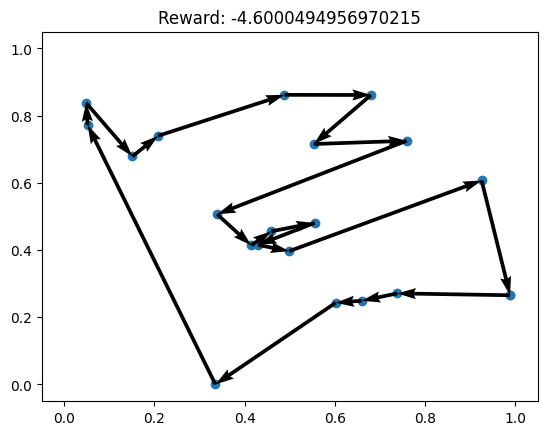

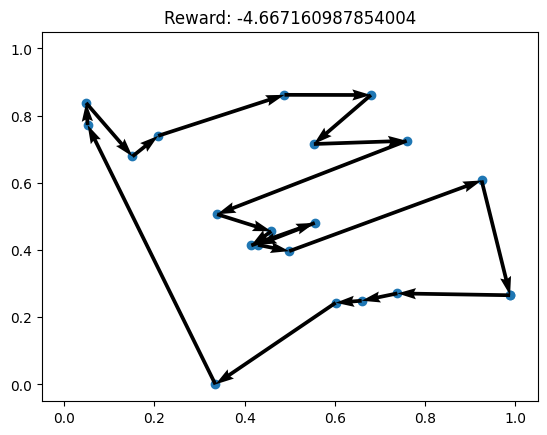

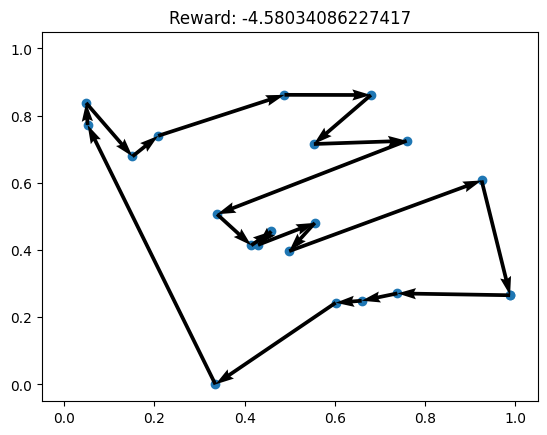

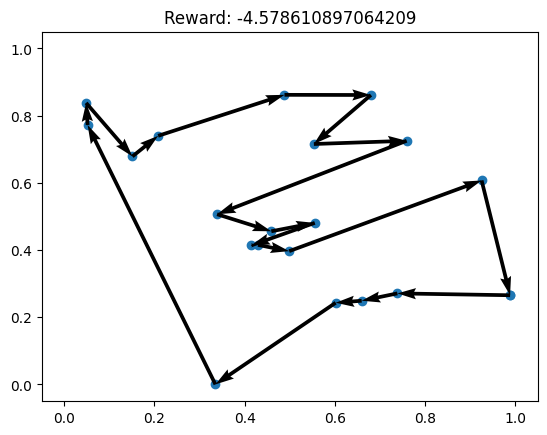

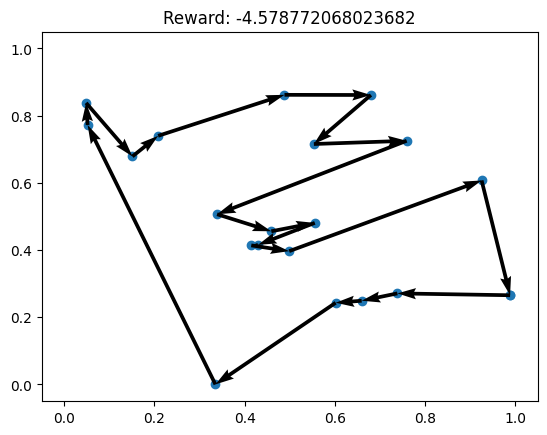

In [12]:
import matplotlib.pyplot as plt
batch_instance = 0
for i, actions in enumerate(actions_stacked[batch_instance].cpu()):
    reward = rewards_stacked[batch_instance, i]
    _, ax = plt.subplots()
    
    env.render(td[0], actions, ax=ax)
    ax.set_title("Reward: %s" % reward.item())

### Final notes

For evaluation, we can also use additional decoding strategies used during evaluatin, such as sampling N times or greedy augmentations, available in [rl4co/tasks/eval.py](../../rl4co/tasks/eval.py)